# Introduction
This notebook serves as documentation for the creation of a regression model with energy consumption as the target variable. The notebook explores and compares several regression models, including ridge regression, elastic net regression, KNN regression, and decision tree regression. The evaluation metrics used to assess the models' performance are R² (coefficient of determination) and mean absolute error.

Towards the end of the notebook, feature explanations are provided using the SHAP (SHapley Additive exPlanations) library. SHAP allows for a deeper understanding of the impact and importance of different features in the regression model.

Overall, this notebook provides a comprehensive overview of the regression model creation process, model evaluation, and feature explanation using the SHAP library.

This is the second of three notebooks.

In [41]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [33]:
# Get the current working directory
current_directory = os.getcwd()

# Read the CSV file into a DataFrame
df = pd.read_csv(os.path.join(current_directory, "df_final.csv"))

In [34]:
# Change the 'CouncilDistrictCode' and 'ZipCode' variables to string type
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].astype(str)
df['ZipCode'] = df['ZipCode'].astype(str)
df=df[~df['SiteEnergyUse(kBtu)_log'].isin([np.inf,-np.inf])].copy()

In [35]:
# Define X and y
X = df[[
    'PrimaryPropertyType', 'ZipCode', 'Neighborhood', 'CouncilDistrictCode',
    'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFAParking', 'LargestPropertyUseType',  'ENERGYSTARScore', 'BuildingAge',
    'parking_area_prcnt', 'PropertyGFATotal_log', 'PropertyGFABuilding(s)_log', 'LargestPropertyUseTypeGFA_log'
]].copy()

y = df['SiteEnergyUse(kBtu)_log']

## Preprocessing

In [36]:
# Initialize the column transformer (with one-hot encoder)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_transform = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown="ignore"),
     ["PrimaryPropertyType", "ZipCode", 'Neighborhood', 'CouncilDistrictCode', 'LargestPropertyUseType'],),
    remainder="passthrough")

# Initialize the StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## Models

In [37]:
# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
# Import necessary packages
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [39]:
# Define candidate parameters for the chosen models
params_ridge = {}
params_ridge["ridge__alpha"] = np.logspace(-5, 5, 5)

params_net = {}
params_net["elasticnet__alpha"] = np.logspace(-5, 5, 5)

params_knn = {}
params_knn["kneighborsregressor__n_neighbors"] = [3, 10, 15]

params_tree = {}
params_tree["decisiontreeregressor__min_samples_leaf"] = [10, 20, 30]
params_tree["decisiontreeregressor__max_depth"] = [10, 15, 30]

params = [params_ridge, params_net, params_knn, params_tree]

In [42]:
# Find the best parameters using GridSearchCV and pipeline
models = [
    Ridge(random_state=42),
    ElasticNet(random_state=42, tol=0.1),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=42)
]

best_params = []
for model, param in zip(models, params):
    pipe = make_pipeline(col_transform, scaler, model)
    grid = GridSearchCV(pipe, param, cv=5, scoring="neg_mean_absolute_error")
    grid.fit(X_train, y_train)
    best_params.append(grid.best_params_)

# Display the best parameters
best_params

[{'ridge__alpha': 1.0},
 {'elasticnet__alpha': 0.0031622776601683794},
 {'kneighborsregressor__n_neighbors': 3},
 {'decisiontreeregressor__max_depth': 10,
  'decisiontreeregressor__min_samples_leaf': 20}]

In [43]:
# Plug in the best parameters
names = ['ridge_regression', 'elastic_net_regression', 'knn_regression', 'decision_tree_regression']

models_best_params = [
    Ridge(random_state=42, alpha=best_params[0]['ridge__alpha']),
    ElasticNet(random_state=42, tol=1, alpha=best_params[1]['elasticnet__alpha']),
    KNeighborsRegressor(n_neighbors=best_params[2]['kneighborsregressor__n_neighbors']),
    DecisionTreeRegressor(random_state=42, max_depth=best_params[3]['decisiontreeregressor__max_depth'], min_samples_leaf=best_params[3]['decisiontreeregressor__min_samples_leaf'])
]

In [44]:
# Create a dataset for plotting the predictions
result_viz = pd.DataFrame(np.exp(y_test))
result_viz.columns = ['target']

# Get the train and test scores, as well as MAE (mean absolute error) for each model
train_score_r2 = []
test_score_r2 = []
train_mae = []
test_mae = []

for model, name in zip(models_best_params, names):
    pipe = make_pipeline(col_transform, scaler, model)
    score_train = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2").mean()
    score_test = cross_val_score(pipe, X_test, y_test, cv=5, scoring="r2").mean()
    mae_train = np.abs(cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean())
    mae_test = np.abs(cross_val_score(pipe, X_test, y_test, cv=5, scoring="neg_mean_absolute_error").mean())

    test_score_r2.append(score_test)
    train_score_r2.append(score_train)
    train_mae.append(mae_train)
    test_mae.append(mae_test)

    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_test)

    # Need to inverse the log function of the target to interpret the result values
    result_viz[name] = np.exp(predict)

# Create a dictionary to store the results
results = {'model': names}
results['train_score_r2'] = train_score_r2
results['test_score_r2'] = test_score_r2
results['train_mean_absolute_error'] = train_mae
results['test_mean_absolute_error'] = test_mae

In [45]:
# Convert the results into a dataframe and display the metrics
model_scores = pd.DataFrame(results)
model_scores = round(model_scores, 2)
pd.options.display.float_format = '{:,}'.format
model_scores.sort_values(by='test_score_r2', ascending=False)

,model,train_score_r2,test_score_r2,train_mean_absolute_error,test_mean_absolute_error
0,ridge_regression,0.76,0.66,0.45,0.51
3,decision_tree_regression,0.67,0.64,0.55,0.57
1,elastic_net_regression,0.64,0.63,0.53,0.55
2,knn_regression,0.45,0.43,0.72,0.72


Based on the metrics obtained, the Ridge regression model demonstrates the highest determination score (r²) and the lowest mean absolute error, indicating superior performance compared to the other three models. Therefore, the Ridge regression model is considered the best among the four models evaluated.

In [46]:
# A table with predicted values on the test set
result_viz = result_viz.sort_values(by="target")
result_viz.reset_index(drop=True, inplace=True)
result_viz.head()

,target,ridge_regression,elastic_net_regression,knn_regression,decision_tree_regression
0,"162,960.00000000015","895,001.7623574167","1,178,886.6295142171","949,809.182141952","1,015,056.9915326004"
1,"241,478.5938000004","482,256.52643187105","486,489.9931042776","328,613.0440861803","583,082.2548153665"
2,"243,518.20309999984","409,571.2388932445","530,134.0489875949","336,465.7455368919","1,015,056.9915326004"
3,"267,135.0937999999","6,918,262.450056097","2,064,101.6769686884","3,218,760.6457171845","3,018,008.6356987883"
4,"313,528.09379999974","391,435.5036445521","468,066.4645662924","2,132,336.3746213387","1,015,056.9915326004"


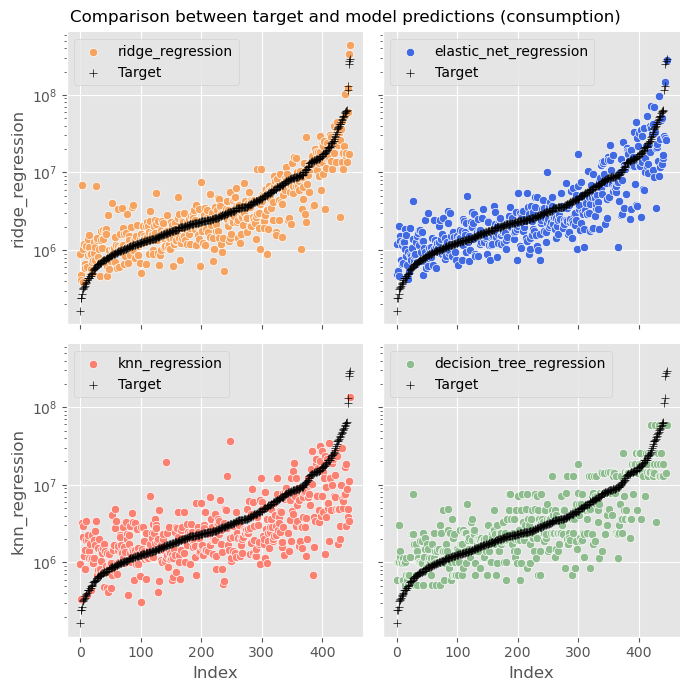

In [47]:
colors = ["sandybrown", "royalblue", "salmon", "darkseagreen"]
cols = ['ridge_regression', 'elastic_net_regression', 'knn_regression', 'decision_tree_regression']

plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(7, 7))

for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(data=result_viz, x=result_viz.index, y=result_viz[cols[i]], color=colors[i], label=cols[i], ax=ax)
    sns.scatterplot(data=result_viz, x=result_viz.index, y=result_viz["target"], color="black", label="Target", marker="+", ax=ax)

    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Index')
    ax.set_yscale("log")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Comparison between target and model predictions (consumption)")
plt.savefig('scatter_plot_results_compare_consumption', bbox_inches='tight', dpi=300)
plt.show()

Les prédictions faites par la régression ridgesont les plus cohérentes avec les valeurs cibles

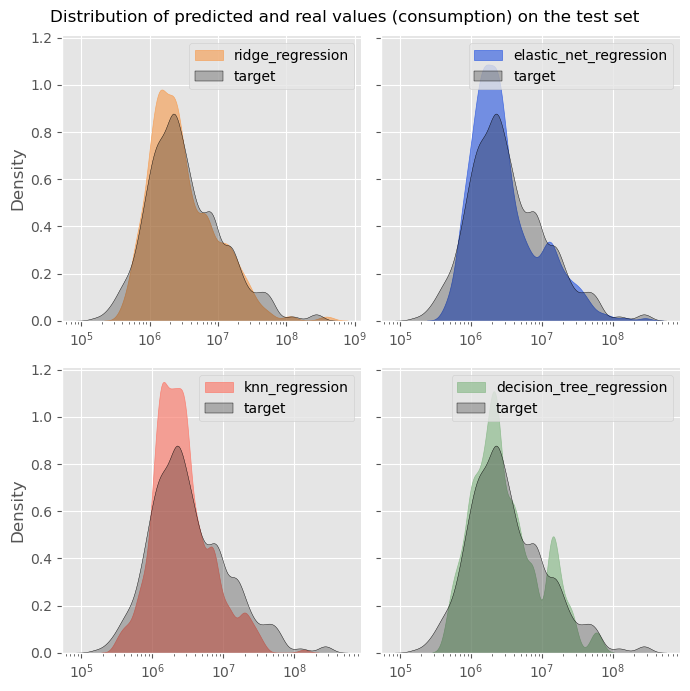

In [48]:
# The predictions made by the Ridge regression are the most consistent with the target values

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(7, 7))

for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(result_viz[cols[i]], shade=True, log_scale=True, bw_adjust=0.6, color=colors[i], ax=ax, label=cols[i], linewidth=0.5, alpha=0.7)
    sns.kdeplot(result_viz['target'], shade=True, log_scale=True, bw_adjust=0.6, color='black', ax=ax, label='target', linewidth=0.3)
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(None)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Distribution of predicted and real values (consumption) on the test set")
plt.savefig('kde_plot_results_compare_consumption', bbox_inches='tight', dpi=300)
plt.show()

Once again, the predictions made by the Ridge regression are the most consistent with the target values.
#he KNN model has significantly under-predicted many values (the clear peak around small values).

## Model interpretation

In [49]:
import shap

# One-hot encode the features
X_one_hot_encoded = pd.DataFrame(col_transform.fit_transform(X), columns=col_transform.get_feature_names_out())

# Scale the one-hot encoded features
X_ohe_scaled = pd.DataFrame(scaler.fit_transform(X_one_hot_encoded), columns=X_one_hot_encoded.columns)

# Fit the Ridge regression model
alpha_ridge = best_params[0]['ridge__alpha']
ridge = Ridge(alpha=alpha_ridge, random_state=42).fit(X_ohe_scaled, y)

In [50]:
# Create the SHAP explainer
explainer_ridge = shap.Explainer(ridge.predict, X_ohe_scaled)

# Compute SHAP values
shap_values_ridge = explainer_ridge(X_ohe_scaled)

Permutation explainer: 1488it [00:32, 33.12it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


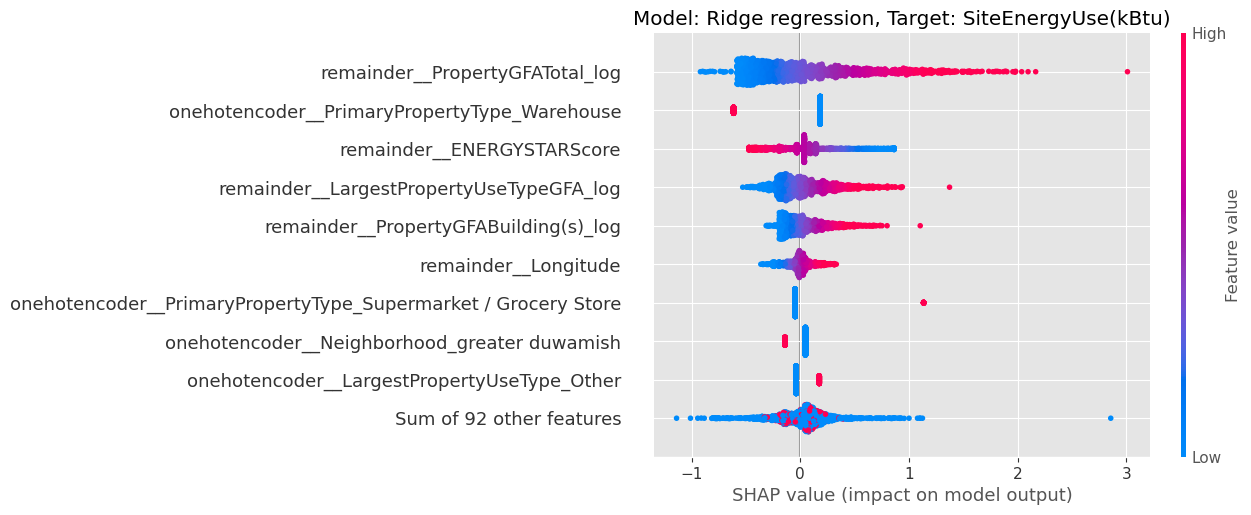

In [51]:
# Plot Bee Swarm plot of SHAP values
fig = shap.plots.beeswarm(shap_values_ridge, max_display=10, show=False)
plt.title('Model: Ridge regression, Target: SiteEnergyUse(kBtu)')
plt.savefig('shap_plot_ridge_beeswarm_consumption', dpi=300, bbox_inches='tight')
plt.show()

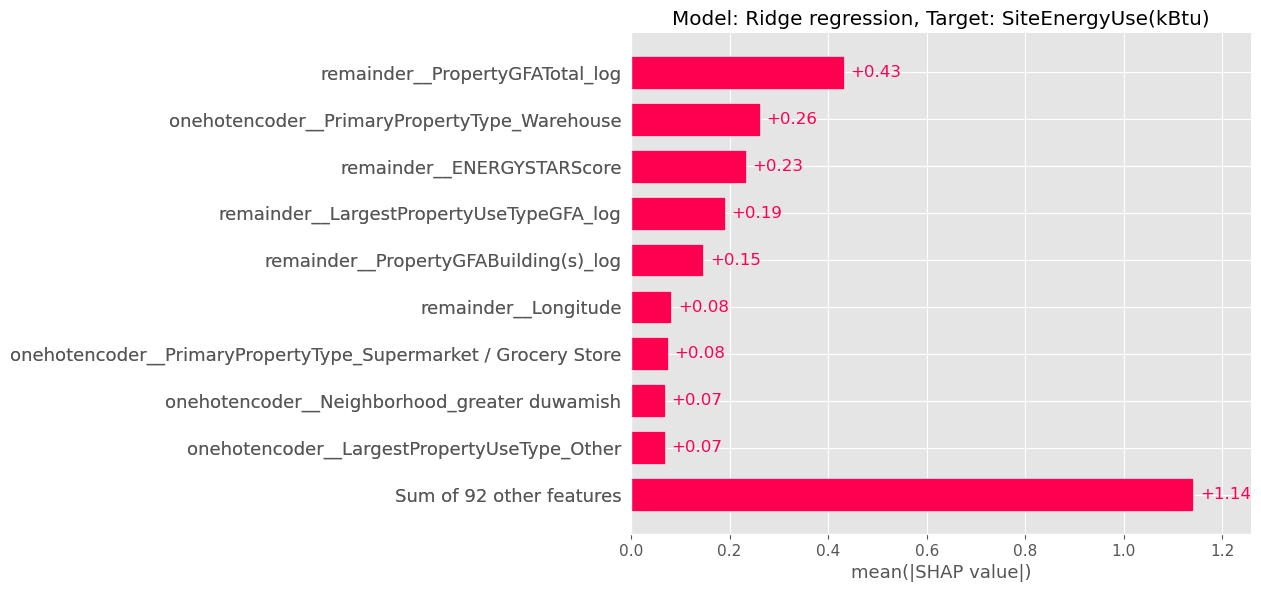

In [52]:
# Plot bar plot of SHAP values
fig = shap.plots.bar(shap_values_ridge, max_display=10, show=False)
plt.title('Model: Ridge regression, Target: SiteEnergyUse(kBtu)')
plt.savefig('shap_plot_ridge_bar_consumption', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
# Individual sample result
sample_index = 2
df.iloc[sample_index, :]

OSEBuildingID                                                                21
PrimaryPropertyType                                                       Other
PropertyName                       The Seattle Public Library - Central Library
Address                                                      1000 Fourth Avenue
ZipCode                                                                   98154
TaxParcelIdentificationNumber                                        0942000275
CouncilDistrictCode                                                           7
Neighborhood                                                           downtown
Latitude                                                               47.60649
Longitude                                                            -122.33297
NumberofBuildings                                                           1.0
NumberofFloors                                                             11.0
PropertyGFATotal                        

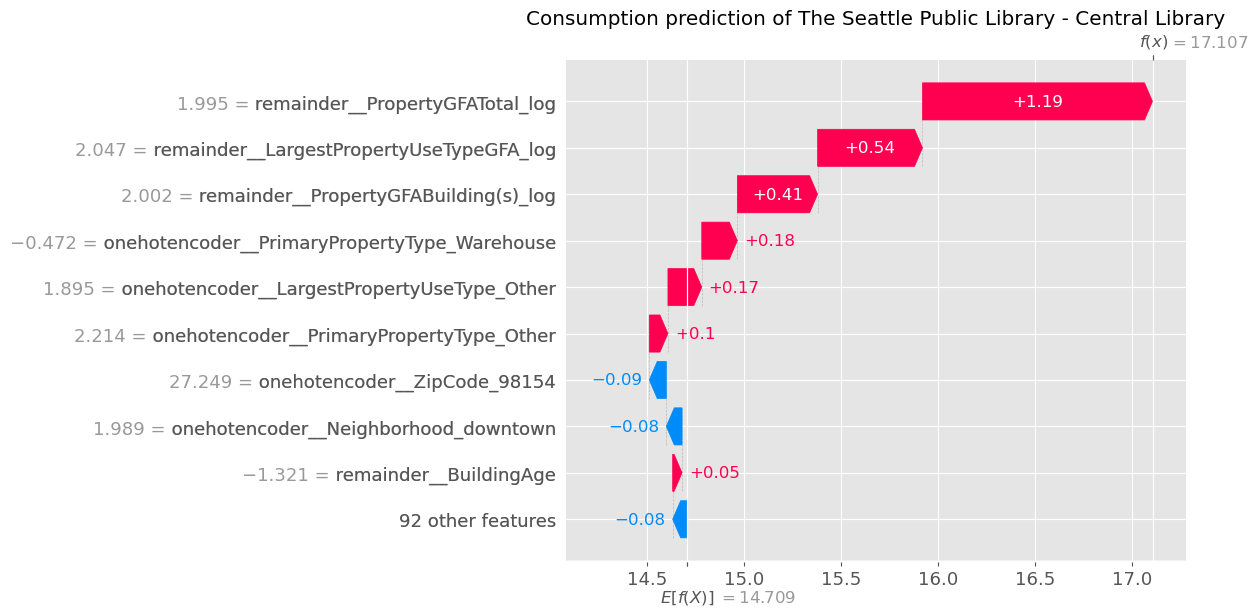

In [54]:
# Plot waterfall plot for individual prediction
shap.plots.waterfall(shap_values_ridge[sample_index], show=False)
plt.title(f"Consumption prediction of {df.loc[sample_index, 'PropertyName']}")
plt.savefig('shap_plot_bar_indiv_consumption', bbox_inches='tight', dpi=300)
plt.show()

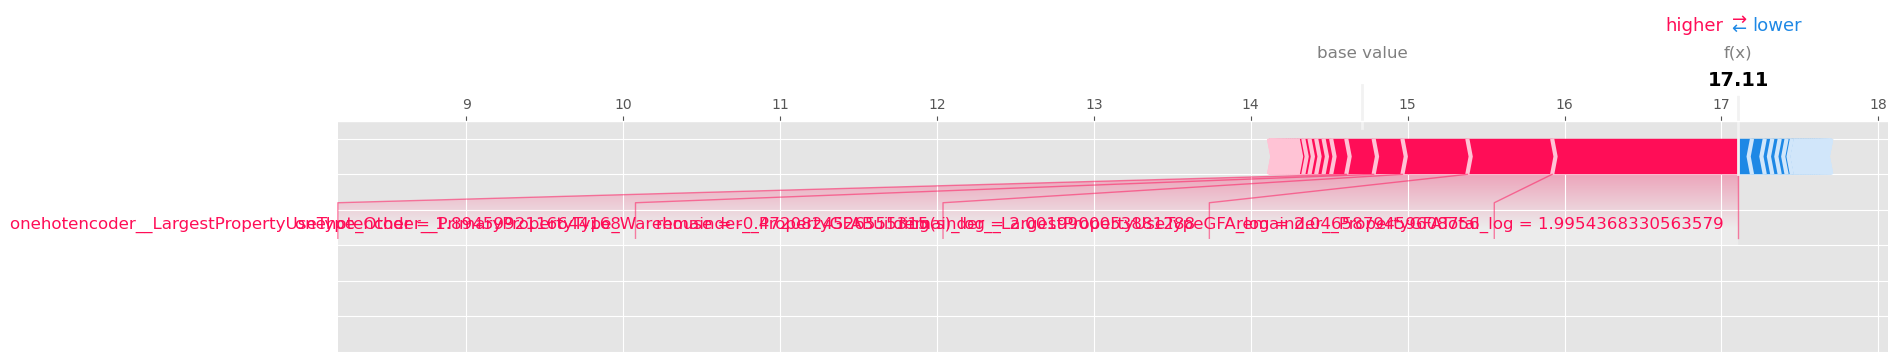

In [55]:
# Plot the force plot for individual prediction
shap.initjs()
shap.plots.force(shap_values_ridge[sample_index], matplotlib=True)